In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import seaborn as sns
customer_info = pd.read_csv('customer_info.csv')
customer_basket = pd.read_csv('customer_basket.csv')

In [4]:
customer_info

,Unnamed: 0,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,0,29930,April Clark,female,01/15/1972 02:27 PM,2.0,2.0,1.0,4.0,7789.0,...,1894.0,457.0,412.0,428.0,386.0,0.158741,2018.0,NaN,38.721807,-9.125534
1,1,6813,Bsc. Paul Ketchum,male,07/31/1944 10:53 AM,0.0,1.0,0.0,4.0,8653.0,...,346.0,394.0,75.0,226.0,73.0,1.227890,2013.0,971840.0,38.734668,-9.163533
2,2,39451,Mary Downing,female,11/13/1989 02:11 PM,2.0,3.0,0.0,7.0,15605.0,...,1971.0,920.0,335.0,192.0,319.0,0.101598,2011.0,NaN,38.787126,-9.147077
3,3,21557,Manuel Kueny,male,08/09/1976 06:23 AM,0.0,0.0,1.0,1.0,13440.0,...,785.0,139.0,679.0,270.0,221.0,0.259943,2009.0,NaN,38.741816,-9.159700
4,4,16415,Phd. Curtis Tharp,male,07/11/1966 08:12 AM,1.0,1.0,1.0,5.0,49250.0,...,1492.0,1046.0,112.0,144.0,244.0,0.317822,2012.0,925367.0,38.785921,-9.149221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34055,34055,37071,Mary Diaz,female,01/20/1999 06:47 PM,1.0,1.0,0.0,2.0,62321.0,...,1687.0,1048.0,379.0,258.0,163.0,0.162331,2018.0,NaN,38.750813,-9.103808
34056,34056,27422,John Gross,male,08/01/1984 07:50 PM,1.0,1.0,0.0,3.0,16084.0,...,568.0,949.0,263.0,319.0,379.0,0.614179,2019.0,985393.0,38.745020,-9.169168
34057,34057,39540,Kathleen Harper,female,09/16/2000 07:22 AM,1.0,0.0,1.0,2.0,14631.0,...,1472.0,368.0,804.0,110.0,228.0,0.535617,2018.0,NaN,38.767834,-9.172368
34058,34058,18367,Msc. Jenny Landry,female,04/09/1961 10:52 AM,1.0,1.0,1.0,4.0,37420.0,...,904.0,1088.0,401.0,376.0,151.0,0.435014,2015.0,953651.0,38.732462,-9.156155


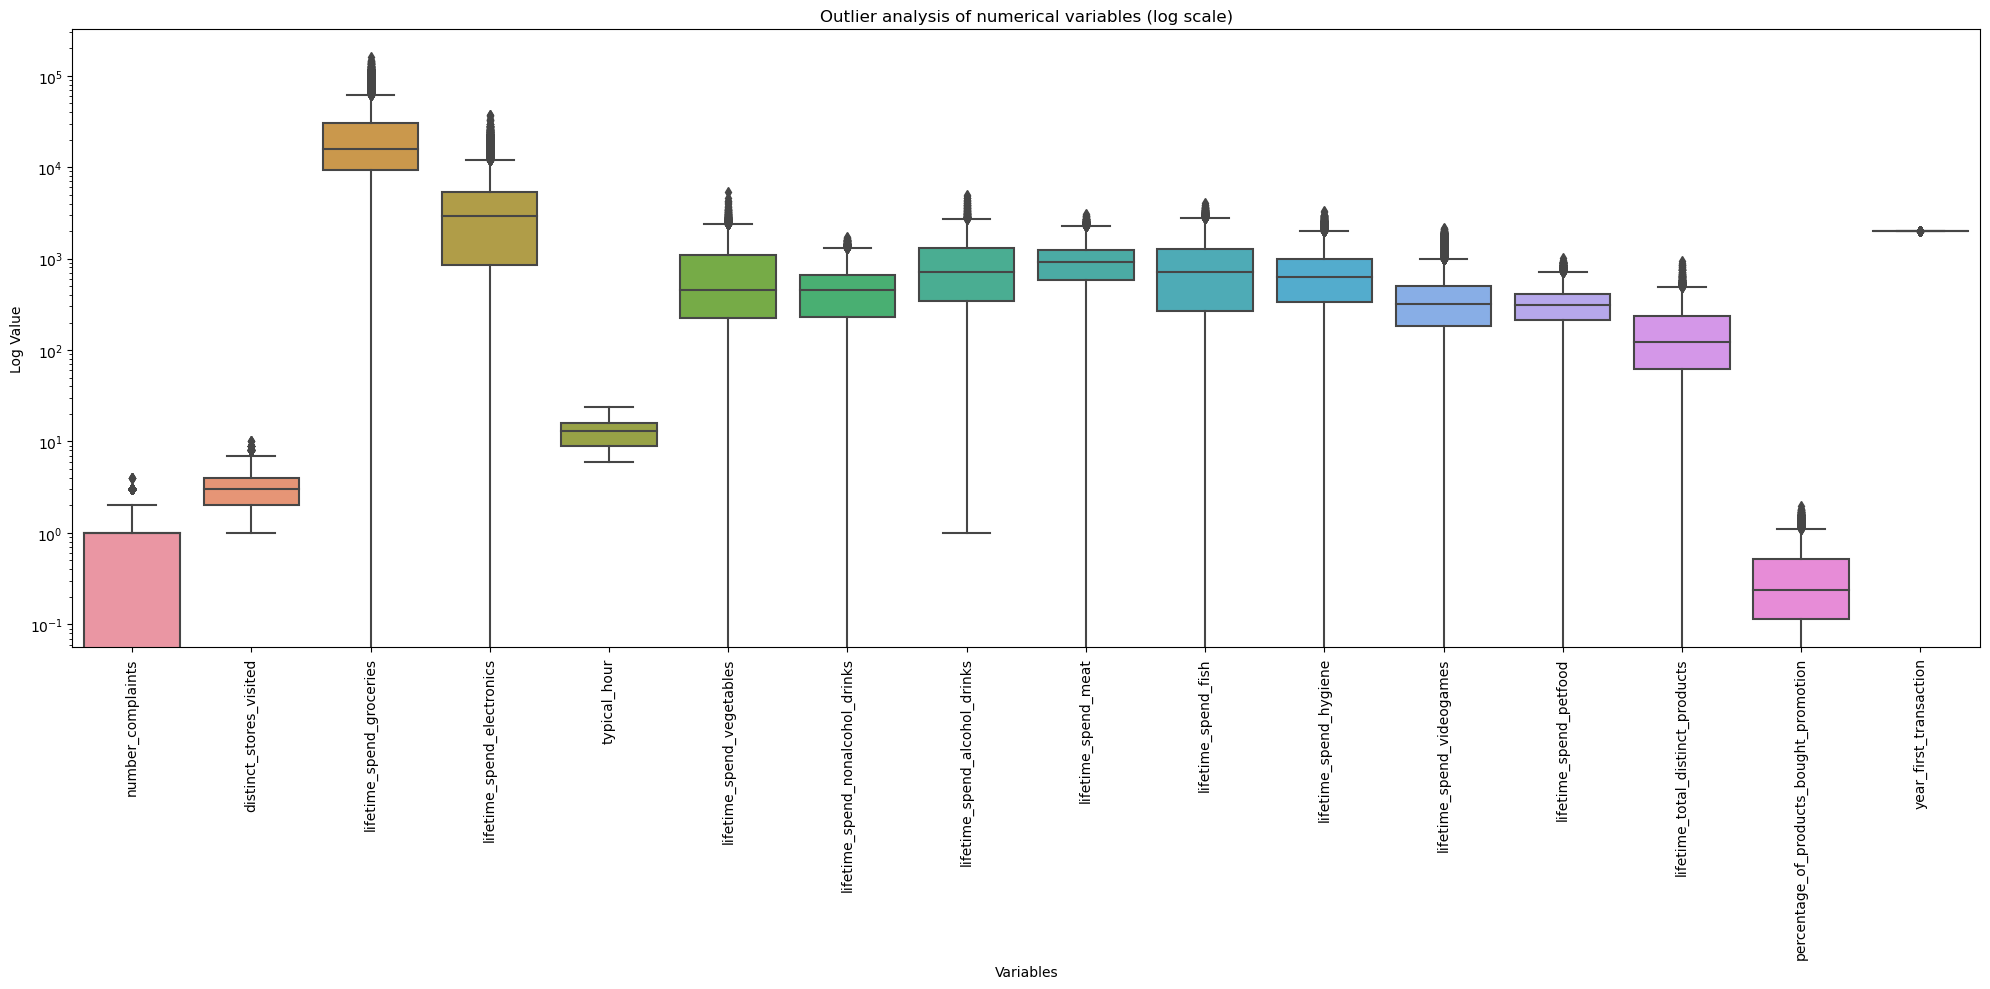

In [20]:
colunas_excluir = ['Unnamed: 0', 'customer_id', 'loyalty_card_number', 'kids_home', 'teens_home', 'latitude', 'longitude']
customer_info = customer_info.drop(columns=[col for col in colunas_excluir if col in customer_info.columns])

df_numerico = customer_info.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_numerico, orient='v')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Outlier analysis of numerical variables (log scale)')
plt.ylabel('Log Value')
plt.xlabel('Variables')
plt.tight_layout()
plt.show()

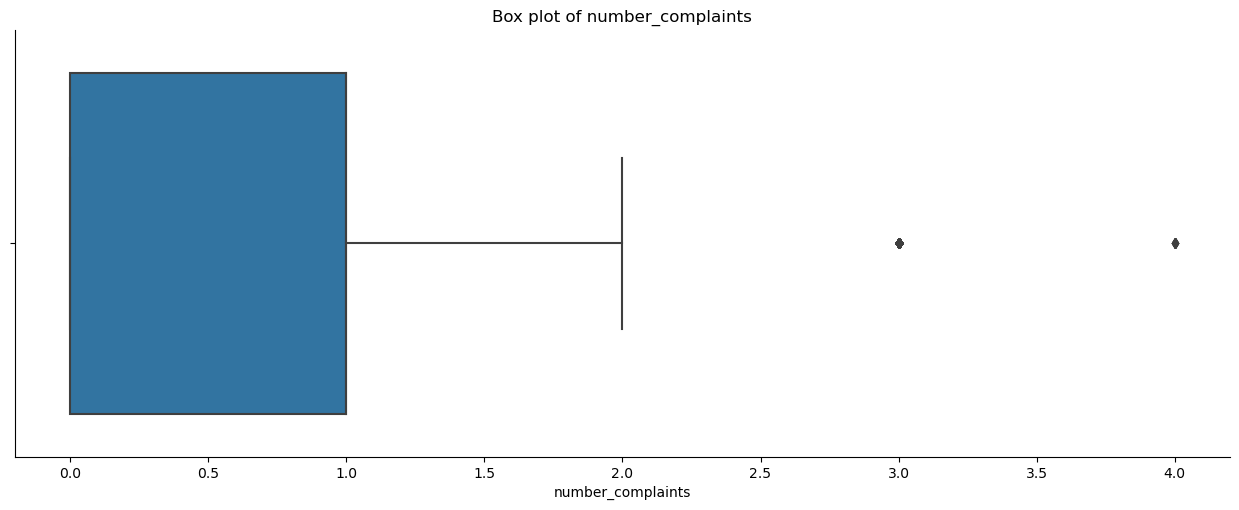

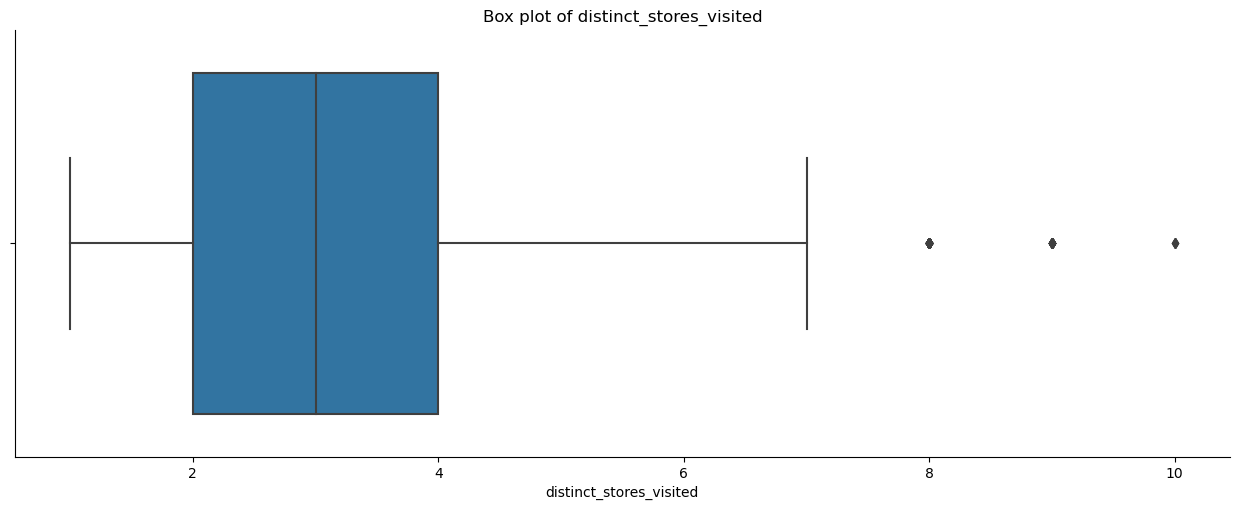

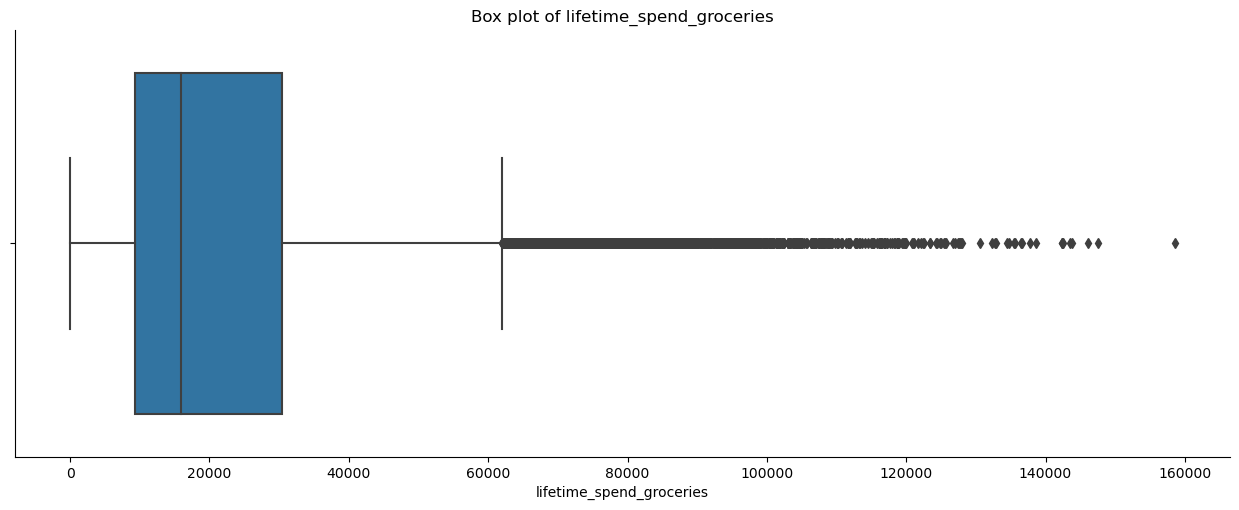

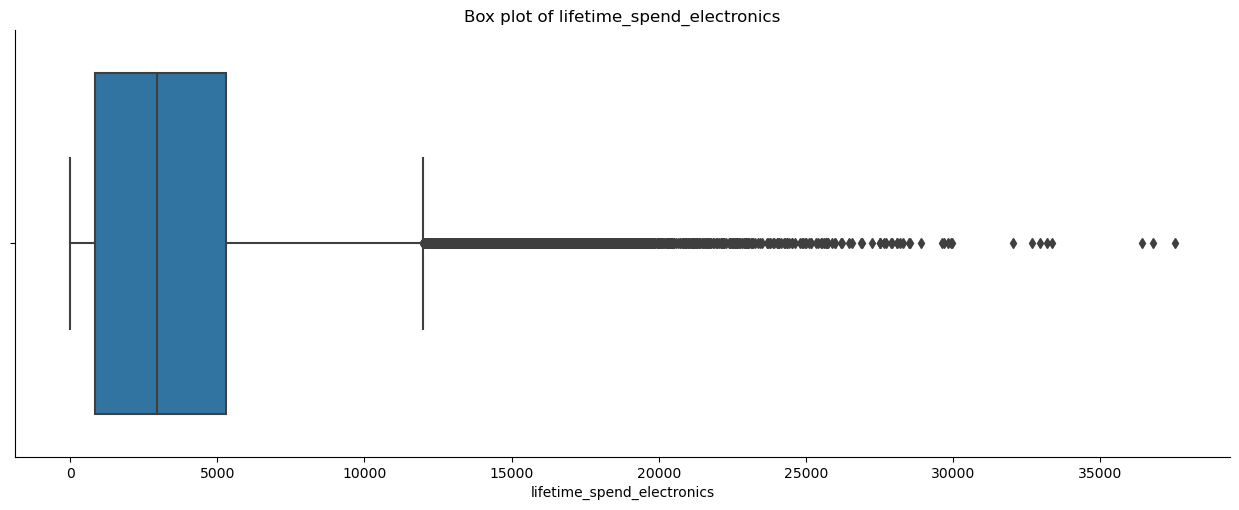

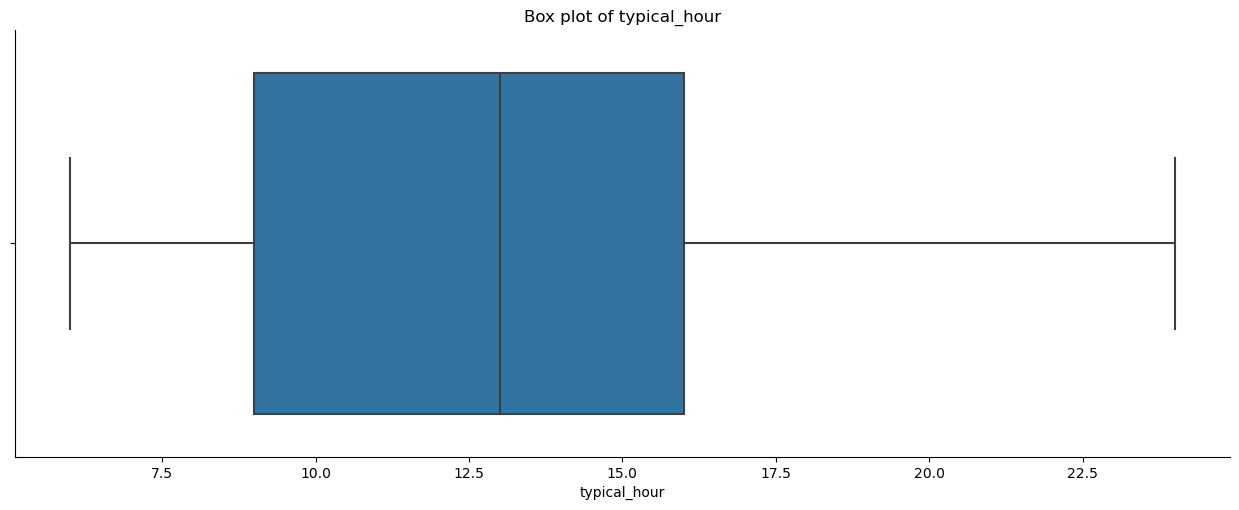

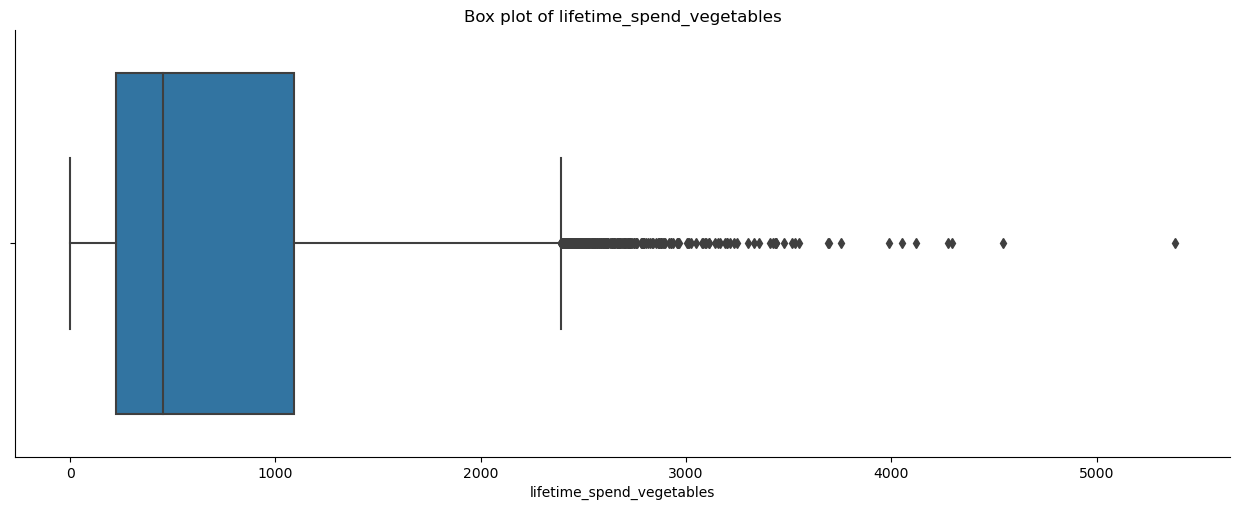

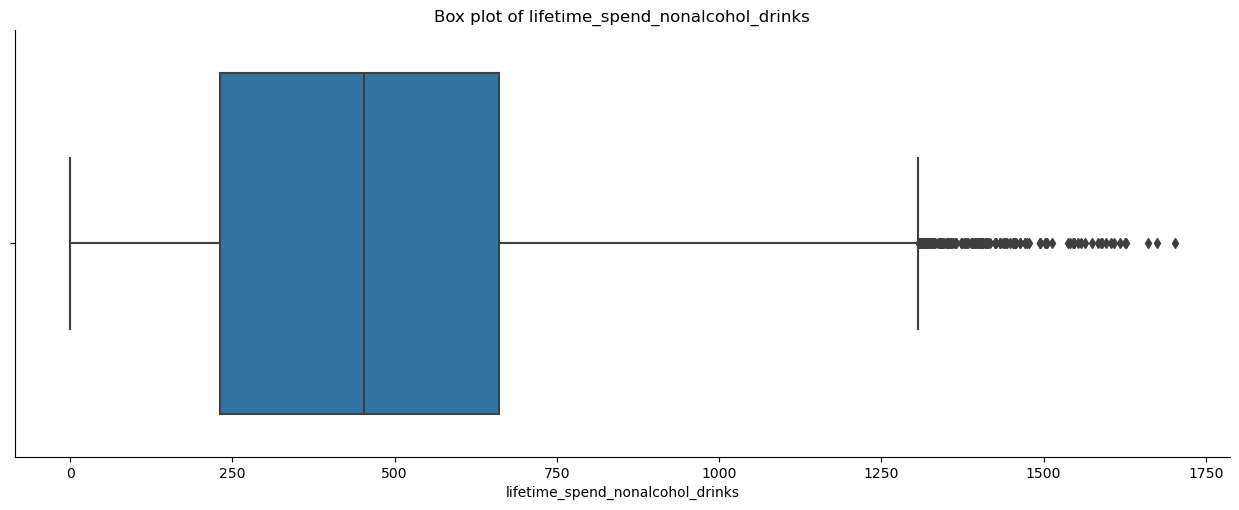

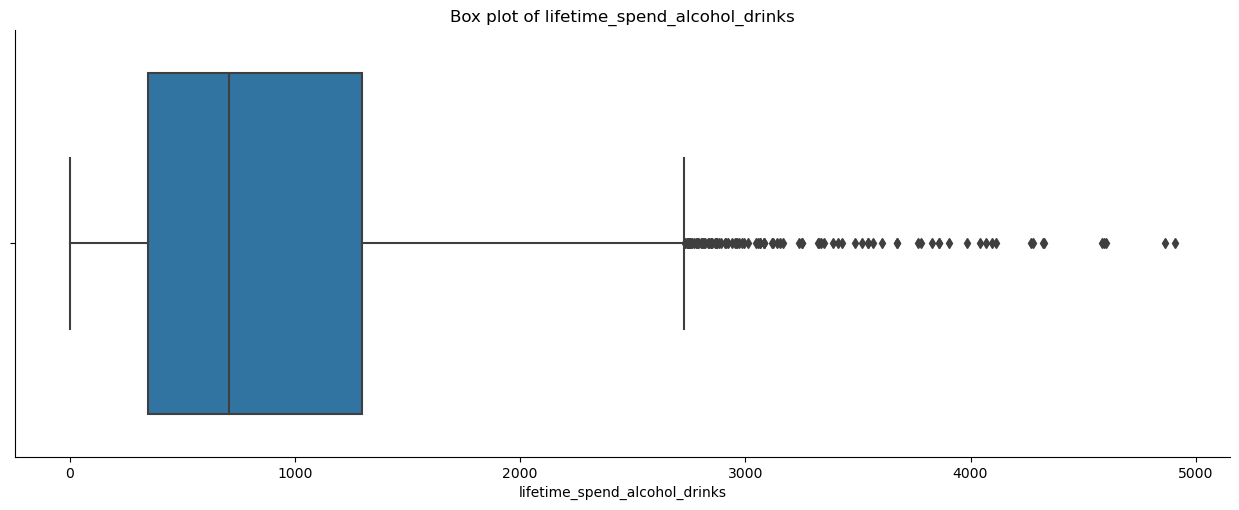

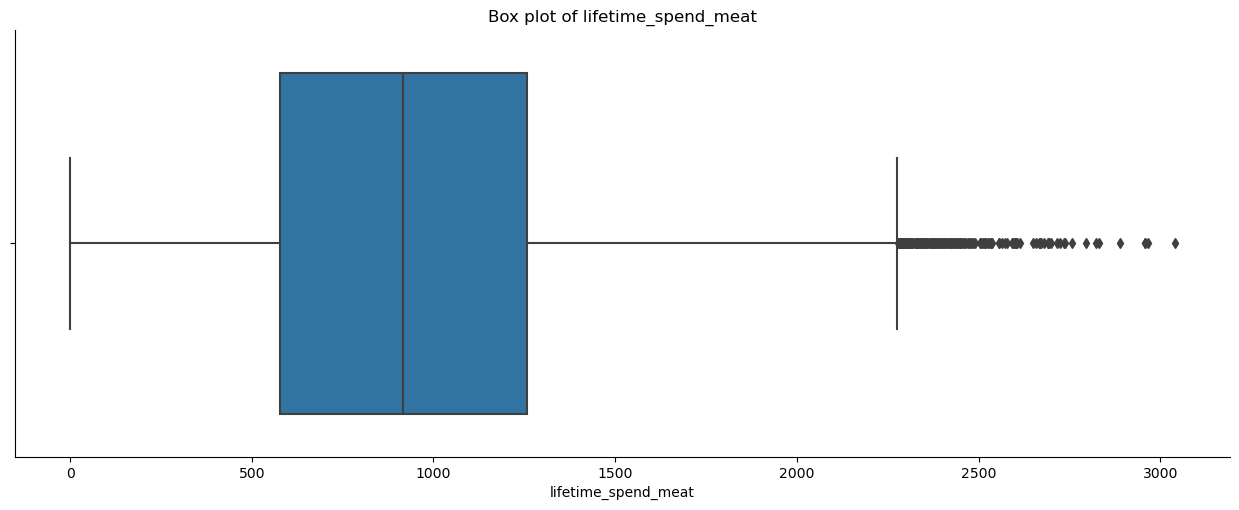

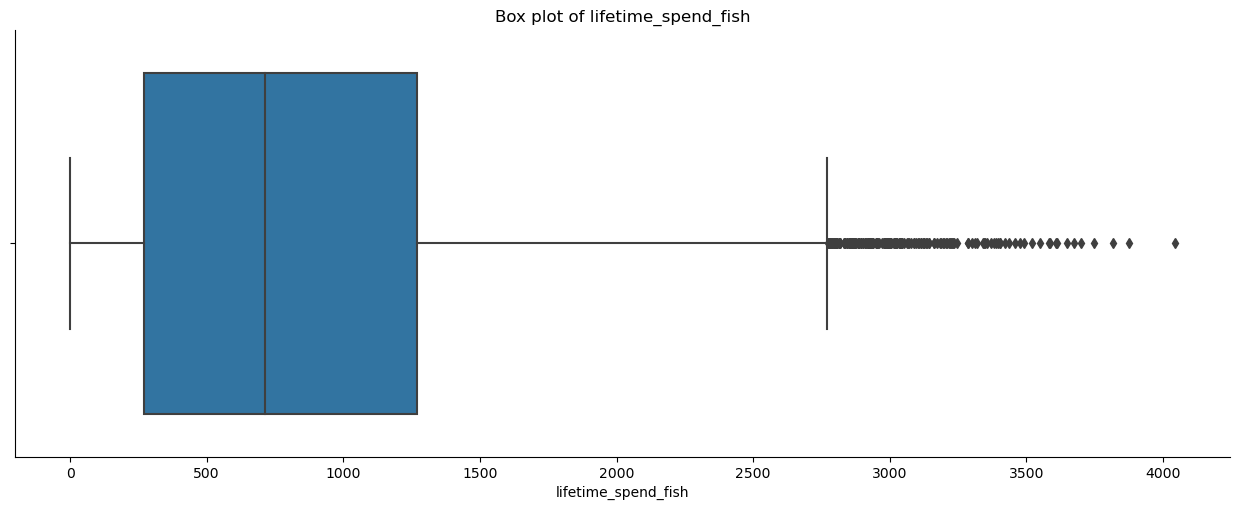

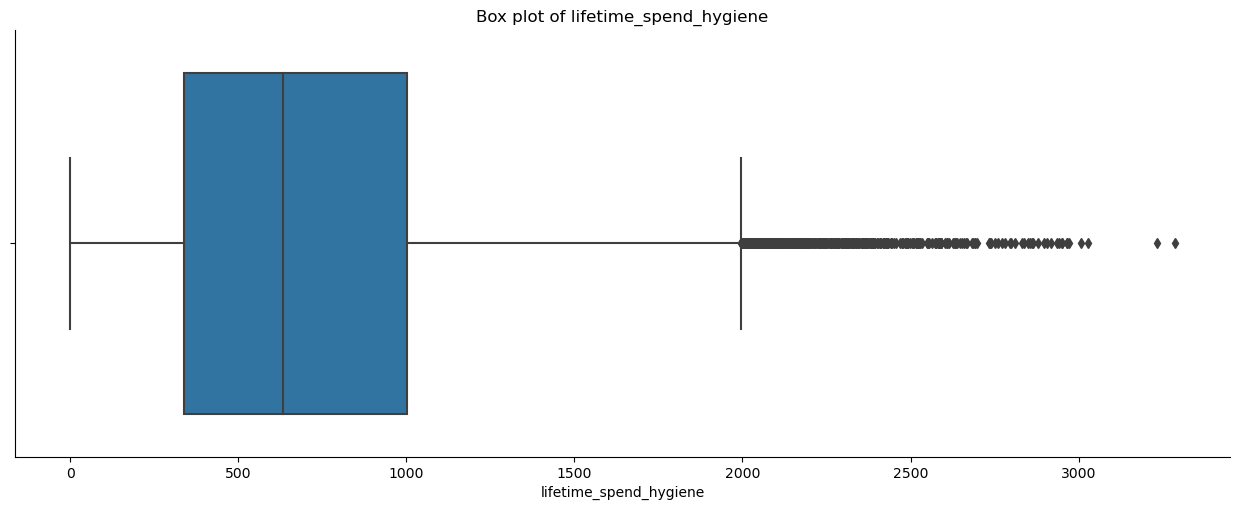

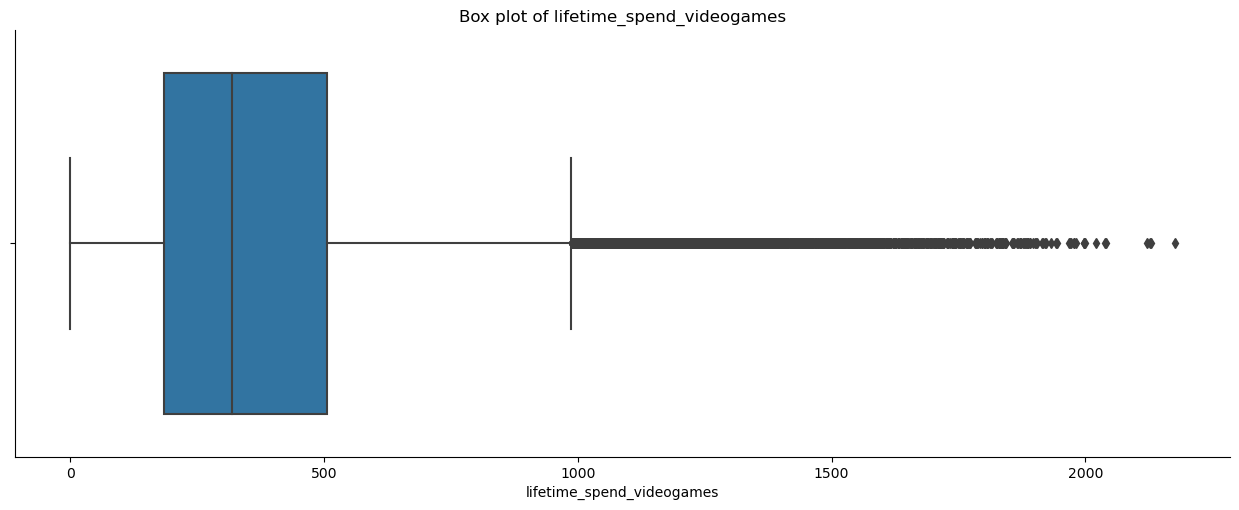

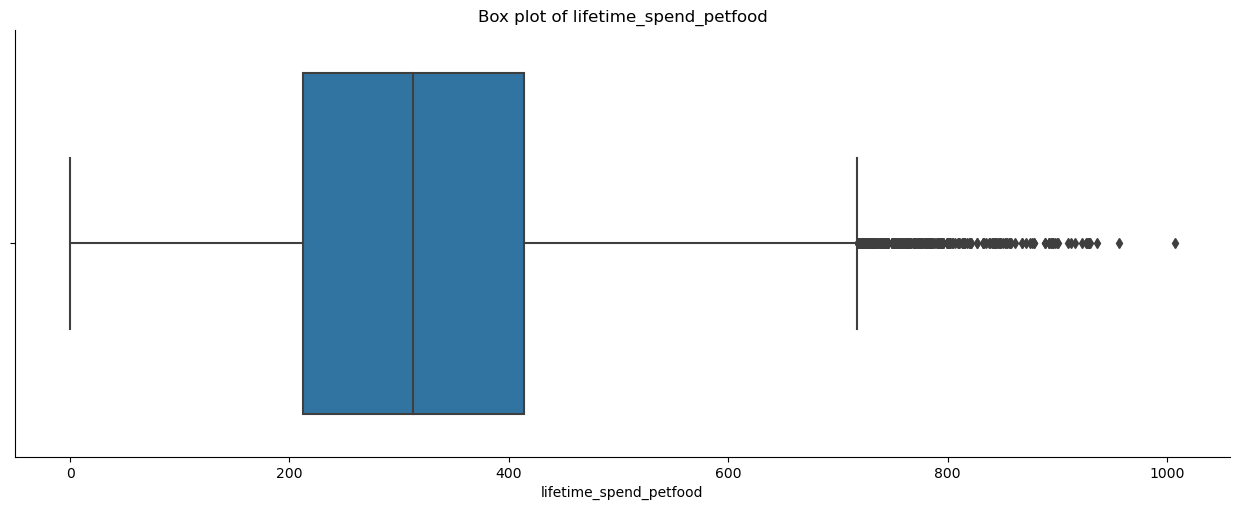

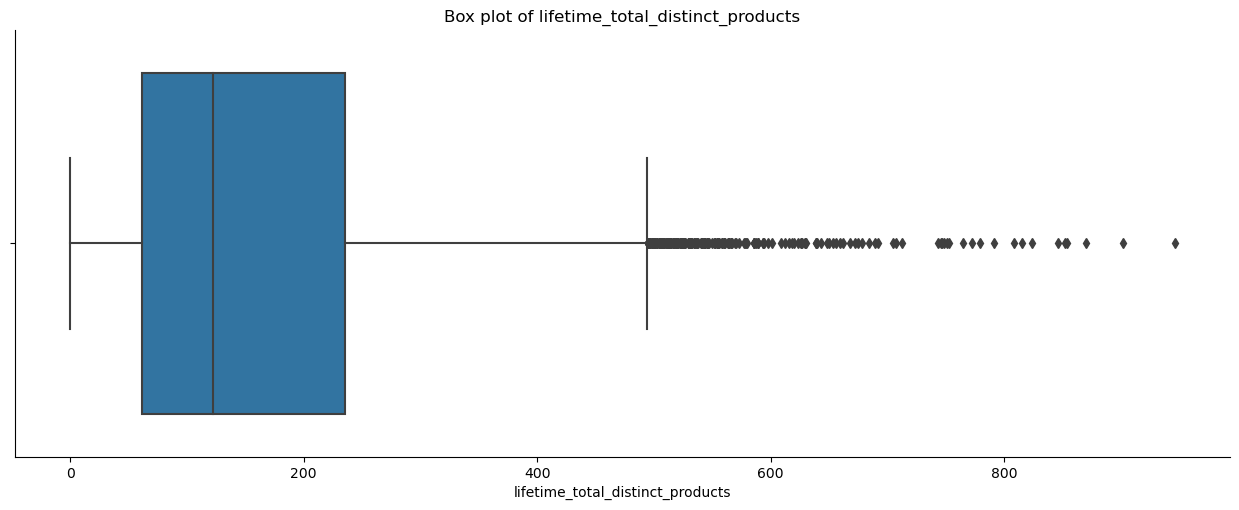

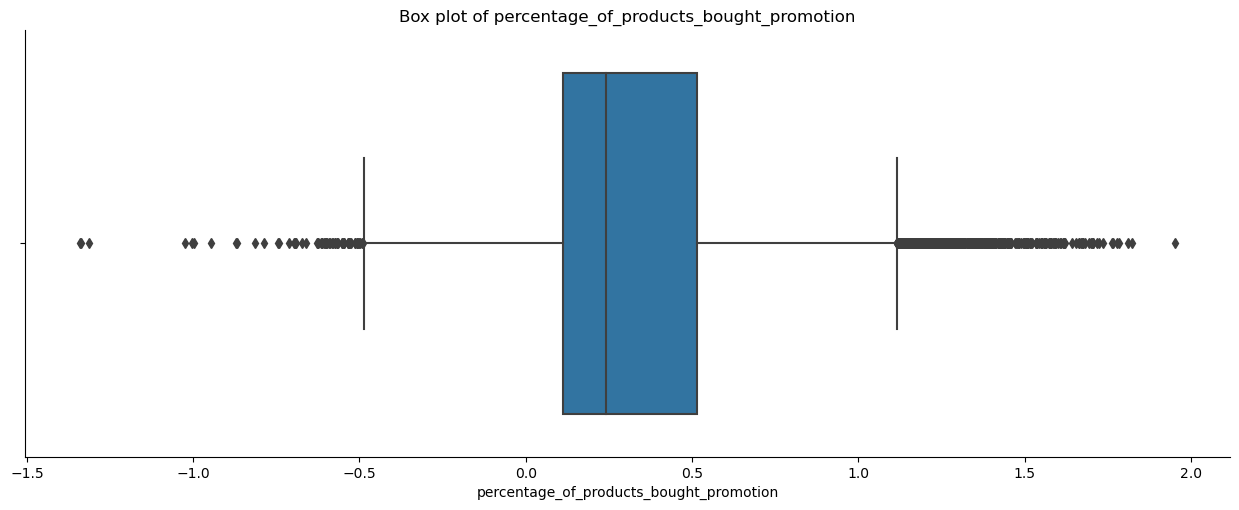

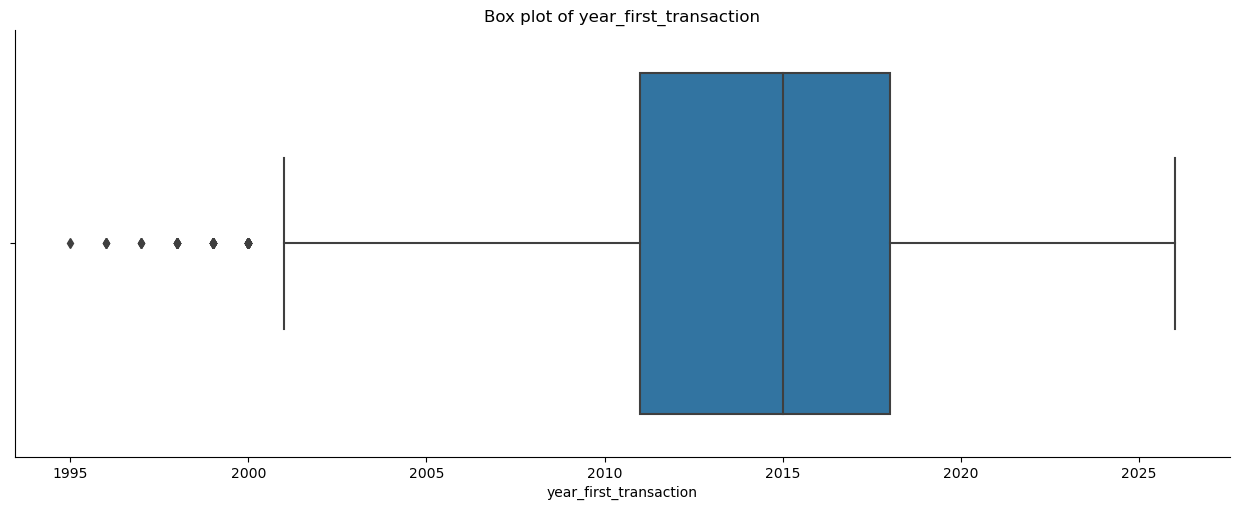

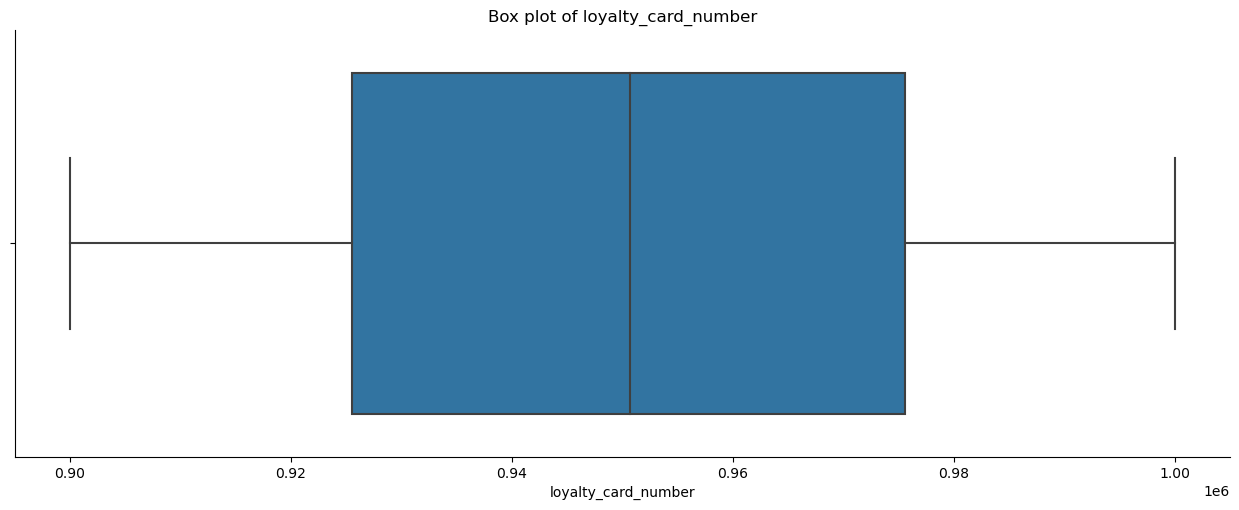

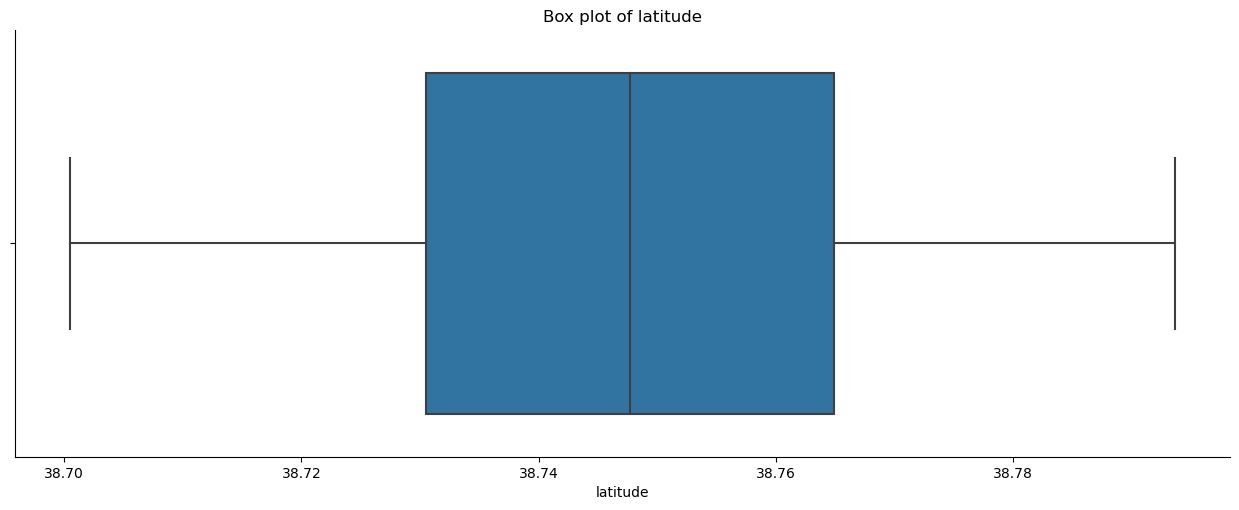

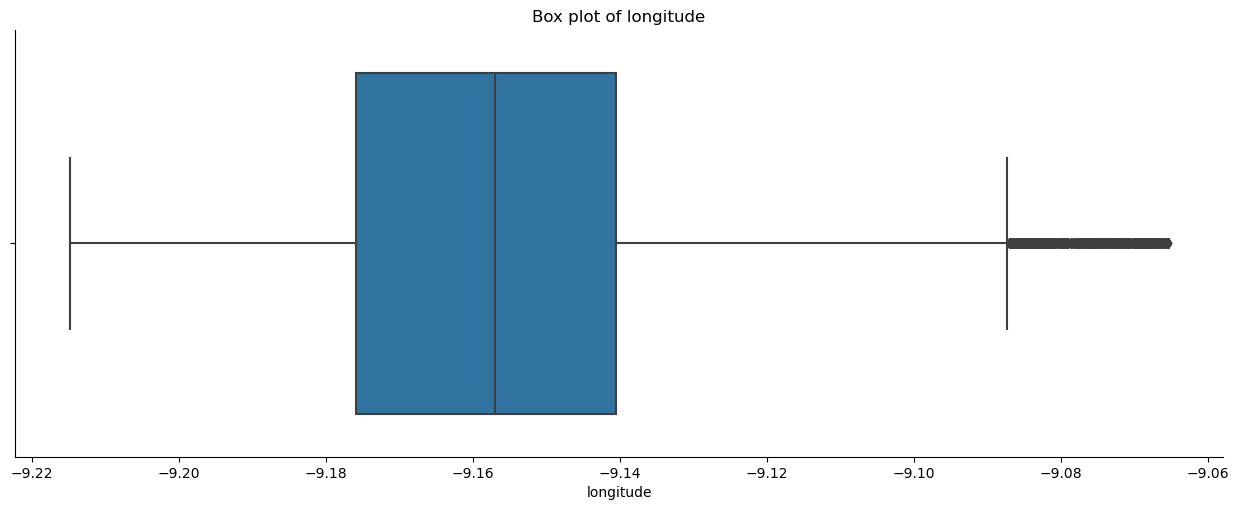

In [6]:
for var in customer_info.describe().columns.drop(['customer_id','Unnamed: 0', 'kids_home', 'teens_home']):
    sns.catplot(data=customer_info, x=var, kind='box', height=5, aspect=2.5)
    plt.title(f'Box plot of {var}')
    plt.show()